# Interpretability Methods: Neuron Synapse Competition
### Logistical Note: Inintally, an Intel Core i7 based Macbook Pro with 16GB of Ram & 1TB of storage was used to design the Interpretations. Despite the advantages of some online platforms such as Google Colab, they come with crucial disavantages, e.g;
1. **User must repeat the same set of actions, i.e., install libraries to execute a task if the device is disconnected, or if user is AFK**
2. **Live editing option is missing on Google Colab**
3. **Google Colab stores files in Google Drive and requires constant login for access**
4. **Google Colab requires users to run at maximum of 12Hrs/day**
5. **RAM limitation is a hinderance and not the best investment**
### Since the Macbook was the most powerful computing machine available to the team, programs were running mostly simultaneously not excluding the homework assignments, therfore reducing the throughput. In November, a New Macbook Pro with 128GB of Unified Memory was introduced. After migrating, the more expensive Interpretation Techniques were fully compiled. 

## Load in and Wrangle Training Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#load in training data on each potential synapse
data = pd.read_csv("./train_data.csv")

#load in additional features for each neuron
feature_weights = pd.read_csv("./feature_weights.csv")
morph_embeddings = pd.read_csv("./morph_embeddings.csv")

#### Basic info on these dataframes

In [ ]:
print("Main Dataframe Size:",data.shape)
print("\nMain Dataframe:")
data.info()

print("\nFeature Weights Size:",feature_weights.shape)
print("\nFeature Weights:")
feature_weights.info(verbose=False)

print("\nMorphological Embeddings Size:",morph_embeddings.shape)
print("\nMorphological Embeddings:")
morph_embeddings.info(verbose=False)

## 1. Merge Data

Before merging, we concatenate the feature weights and morphological embeddings into np.array's to decrease memory usage.

In [ ]:
# join all feature_weight_i columns into a single np.array column
feature_weights["feature_weights"] = (
    feature_weights.filter(regex="feature_weight_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)
# delete the feature_weight_i columns
feature_weights.drop(
    feature_weights.filter(regex="feature_weight_").columns, axis=1, inplace=True
)

# join all morph_embed_i columns into a single np.array column
morph_embeddings["morph_embeddings"] = (
    morph_embeddings.filter(regex="morph_emb_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)
# delete the morph_embed_i columns
morph_embeddings.drop(
    morph_embeddings.filter(regex="morph_emb_").columns, axis=1, inplace=True
)

In [ ]:
data = (
    data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)

In [ ]:
print("Data Size:",data.shape)
print("\nData:")
data.info()

## Basic Exploratory Analysis

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

### Unbalanced Data

The outcomes, the adps that form a connection or synapse ('connected'==True) and the adps that do not synapse ('connected'==False), are unbalanced:

In [ ]:
print("Number Connected (Synapses):",data['connected'].sum())

print("\nNumber Not Connected:",(~data['connected']).sum())

The number of presynaptic neurons and postsynaptic neurons are also unbalanced:

In [ ]:
print(f"All the adps are from {data['pre_nucleus_id'].nunique()} pre- neurons and {data['post_nucleus_id'].nunique()} post- neurons.")

### Exploration: Feature Plots 

Neurons that form a synpase ('connected') tend to be closer together (smaller distance between pre- and post-synaptic ADP - 'adp_dist').

## Basic Feature Engineering

In [ ]:
#cosine similarity function
def row_feature_similarity(row):
    pre = row["pre_feature_weights"]
    post = row["post_feature_weights"]
    return (pre * post).sum() / (np.linalg.norm(pre) * np.linalg.norm(post))

def xCoorDifference(row):
    dendriticX = row["dendritic_coor_x"]
    axonalX = row["axonal_coor_x"]
    return abs(dendriticX - axonalX)
def yCoorDifference(row):
    dendriticY = row["dendritic_coor_y"]
    axonalY = row["axonal_coor_y"]
    return abs(dendriticY - axonalY)
def zCoorDifference(row):
    dendriticZ = row["dendritic_coor_z"]
    axonalZ = row["axonal_coor_z"]
    return abs(dendriticZ - axonalZ)

def EDax_denDist(row):
#def xCoorDifference(row):
    dendriticX = row["dendritic_coor_x"]
    axonalX = row["axonal_coor_x"]
    #return abs(dendriticX - axonalX)
#def yCoorDifference(row):
    dendriticY = row["dendritic_coor_y"]
    axonalY = row["axonal_coor_y"]
    #return abs(dendriticY - axonalY)
#def zCoorDifference(row):
    dendriticZ = row["dendritic_coor_z"]
    axonalZ = row["axonal_coor_z"]
    #return abs(dendriticZ - axonalZ)
    return ((dendriticX - axonalX)**2 
            + (dendriticY - axonalY)**2 
            + (dendriticZ - axonalZ)**2)**(1/2)

def EDpre_postnucleusDist(row):
    preNucleusX = row["pre_nucleus_x"]
    preNucleusY = row["pre_nucleus_y"]
    preNucleusZ = row["pre_nucleus_z"]

    postNucleusX = row["post_nucleus_x"]
    postNucleusY = row["post_nucleus_y"]
    postNucleusZ = row["post_nucleus_z"]
    return np.sqrt((preNucleusX-postNucleusX)**2 
                   + (preNucleusY-postNucleusY)**2 
                   + (preNucleusZ-postNucleusZ)**2)

def thetaDiff(row):
    pre_orientation_vector_X = row["axonal_coor_x"] - row["pre_nucleus_x"]
    pre_orientation_vector_Y = row["axonal_coor_y"] - row["pre_nucleus_y"]
    pre_orientation_vector_Z = row["axonal_coor_z"] - row["pre_nucleus_z"]

    post_orientation_vector_X = row["dendritic_coor_x"] - row["post_nucleus_x"]
    post_orientation_vector_Y = row["dendritic_coor_y"] - row["post_nucleus_y"]
    post_orientation_vector_Z = row["dendritic_coor_z"] - row["post_nucleus_z"]
    
    numerator = (pre_orientation_vector_X
                 * post_orientation_vector_X
                 + pre_orientation_vector_Y * post_orientation_vector_Y
                 + pre_orientation_vector_Z * post_orientation_vector_Z
                 )
    denominator = (np.sqrt(pre_orientation_vector_X**2
                    + pre_orientation_vector_Y**2
                    + pre_orientation_vector_Z**2)
                    * (np.sqrt(post_orientation_vector_X**2
                    + post_orientation_vector_Y**2
                    + post_orientation_vector_Z**2))
                   )
    cos_theta = numerator / denominator
    actual_angle = np.arccos(cos_theta)*(180/np.pi)
    return actual_angle / 180

#cosine similarity function
def row_morphEmbed_similarity(row):
    pre = row["pre_morph_embeddings"]
    post = row["post_morph_embeddings"]
    return (pre * post).sum() / (np.linalg.norm(pre) * np.linalg.norm(post))

# location slicer relative to lop left of monitor
def preRadialLocation(row):
    pre = row["pre_rf_x"]
    post = row["pre_rf_y"]
    return np.sqrt(pre**2 * post**2)

def postRadialLocation(row):
    pre = row["post_rf_x"]
    post = row["post_rf_y"]
    return np.sqrt(pre**2 * post**2)

def oracleDiff(row):
    pre = row["pre_oracle"]
    post = row["post_oracle"]
    return pre * post

def testScoreDiff(row):
    pre = row["pre_test_score"]
    post = row["post_test_score"]
    return pre * post

def EDax_denDistSquared(row):
    return row["3Dax_denDist"]**2

def cumulativeCoordinateDifference(row):
    return (row["coorX_difference"] + row["coorY_difference"] + row["coorZ_difference"])

def productCoordinateDifference(row):
    return (row["coorX_difference"] * row["coorY_difference"] * row["coorZ_difference"])


In [ ]:
# compute the cosine similarity between the pre- and post- feature weights
data["fw_similarity"] = data.apply(row_feature_similarity, axis=1)
# compute the cosine similarity between the pre- and post- morphological embeddings
data["morphEm_similarity"] = data.apply(row_morphEmbed_similarity, axis=1)
# compute the difference between the X-coordinates
data["coorX_difference"] = data.apply(xCoorDifference, axis=1)
# compute the difference between the Y-coordinates
data["coorY_difference"] = data.apply(yCoorDifference, axis=1)
# compute the difference between the Z-coordinates
data["coorZ_difference"] = data.apply(zCoorDifference, axis=1)
# Theta between 2 neurons
data["theta_btwn_2neurons"] = data.apply(thetaDiff, axis =1)
# 3D distance between axon and dendrite 
data["3Dax_denDist"] = data.apply(EDax_denDist, axis=1)
# 3D distance between pre and post nucleus distance
data["3Dpre_postNucleusDist"] = data.apply(EDpre_postnucleusDist, axis=1)
# Pre radial location
data["preRadialLocation"] = data.apply(preRadialLocation, axis=1)
# Post radial location
data["postRadialLocation"] = data.apply(postRadialLocation, axis=1)
# Combined Oracle Score of Pre-synaptic and Post-synaptic Neurons:
data["Combined_oracle"] = data.apply(oracleDiff, axis=1)
# pre and post test score difference 
data["Combined_testScore"] = data.apply(testScoreDiff, axis=1)
data["CumCoorDiff"] = data.apply(cumulativeCoordinateDifference, axis=1)
data["EDax_denDistSquared"] = data.apply(EDax_denDistSquared, axis=1)
data["ProdCoorDiff"] = data.apply(productCoordinateDifference, axis=1)

In [ ]:
#visualize these results
sns.catplot(data=data, x='connected', y='fw_similarity', kind='boxen')
sns.catplot(data=data, x='connected', y='coorX_difference', kind='boxen')
sns.catplot(data=data, x='connected', y='coorY_difference', kind='boxen')
sns.catplot(data=data, x='connected', y='coorZ_difference', kind='boxen')
sns.catplot(data=data, x='connected', y='theta_btwn_2neurons', kind='boxen')
sns.catplot(data=data, x='connected', y='3Dax_denDist', kind='boxen')
sns.catplot(data=data, x='connected', y='3Dpre_postNucleusDist', kind='boxen')
sns.catplot(data=data, x='connected', y='preRadialLocation', kind='boxen')
sns.catplot(data=data, x='connected', y='postRadialLocation', kind='boxen')
sns.catplot(data=data, x='connected', y='Combined_oracle', kind='boxen')
sns.catplot(data=data, x='connected', y='Combined_testScore', kind='boxen')

There may be a very, very slight difference, but we can investigate this further.

### Exploration: Similar functional nerual responses by projection region in the brain

    Projection regions indicate the brain regions where the pre-synaptic and post-synaptic neurons are located in the brain.  Each brain region is responsible for different neural functions.  We can engineer a new feature to capture the projection regions and perhaps see if similar neural tuning is affiliated with connecitons in particular projection regions.  For example, it has been shown that connected neurons have slightly more similar neural tuning than unconnected neurons in the V1->V1 projection region.

In [ ]:
# generate projection group as pre->post
data["projection_group"] = (
    data["pre_brain_area"].astype(str)
    + "->"
    + data["post_brain_area"].astype(str)
)

## 1.1. Final Merging of Columns

### Load and Merge Leaderboard Data

In [ ]:
#we need to first load and merge the leaderboard data to have the same format as the training set
lb_data = pd.read_csv("./leaderboard_data.csv")

In [ ]:
lb_data = (
    lb_data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)

In [ ]:
lb_data.shape
lb_data.head

## 1.2. Leaderboard dataframe

All engineered features are also added to the Leaderboard dataframe.

In [ ]:
# compute the cosine similarity between the pre- and post- feature weights 
lb_data["fw_similarity"] = lb_data.apply(row_feature_similarity, axis=1)
# compute the cosine similarity between the pre- and post- morphological embeddings 
lb_data["morphEm_similarity"] = lb_data.apply(row_morphEmbed_similarity, axis=1)
# compute the cosine similarity between the X-coordinates 
lb_data["coorX_difference"] = lb_data.apply(xCoorDifference, axis=1)
# compute the cosine similarity between the Y-coordinates 
lb_data["coorY_difference"] = lb_data.apply(yCoorDifference, axis=1)
# compute the cosine similarity between the Z-coordinates 
lb_data["coorZ_difference"] = lb_data.apply(zCoorDifference, axis=1)
lb_data["theta_btwn_2neurons"] = lb_data.apply(thetaDiff, axis = 1)
# 3D distance between axon and dendrite 
lb_data["3Dax_denDist"] = lb_data.apply(EDax_denDist, axis=1)
# 3D distance between pre and post nucleus distance
lb_data["3Dpre_postNucleusDist"] = lb_data.apply(EDpre_postnucleusDist, axis=1)
# Pre radial location 
lb_data["preRadialLocation"] = lb_data.apply(preRadialLocation, axis=1)
# Post radial location 
lb_data["postRadialLocation"] = lb_data.apply(postRadialLocation, axis=1)
# pre and post oracle difference 
lb_data["Combined_oracle"] = lb_data.apply(oracleDiff, axis=1)
# pre and post test score difference 
lb_data["Combined_testScore"] = lb_data.apply(testScoreDiff, axis=1)
lb_data["CumCoorDiff"] = data.apply(cumulativeCoordinateDifference, axis=1)
lb_data["EDax_denDistSquared"] = data.apply(EDax_denDistSquared, axis=1)
lb_data["ProdCoorDiff"] = data.apply(productCoordinateDifference, axis=1)

## 2.0. Feature Importance: Logistic Regression

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold, StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
import scipy.cluster.hierarchy as sch
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

# Splitting features into numerical, categorical, and one to impute
numerical_features = ["coorZ_difference", "coorY_difference", "coorX_difference",
                    "adp_dist", "post_skeletal_distance_to_soma", "pre_rf_y", "pre_skeletal_distance_to_soma",
                    "dendritic_coor_x", "dendritic_coor_y", "fw_similarity", "post_nucleus_id", 
                    "pre_nucleus_id", "dendritic_coor_z", "axonal_coor_x", 
                    "axonal_coor_y", "axonal_coor_z", 
                    "pre_test_score", "pre_rf_x", "post_test_score", 
                    "post_rf_x", "theta_btwn_2neurons", "Combined_oracle", "Combined_testScore",
                    "morphEm_similarity"
]
categorical_features = ["compartment", "pre_brain_area", "post_brain_area"]
predict_features = numerical_features + categorical_features

# Split the data
X = data[predict_features]
y = data["connected"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

# Preprocessing: ColumnTransformer will handle encoding, scaling, and imputing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features),
        ('impute', SimpleImputer(strategy='median'), ['morphEm_similarity'])
    ])

# Define resampling and model parameters
resampler = RandomOverSampler(random_state=5)
model = xgb.XGBClassifier()
params = {
    'model__n_estimators': [135],
    'model__learning_rate': [0.0001],
    'model__max_depth': [6],
    'model__subsample': [1.0],
    'model__colsample_bytree': [0.2],
    'model__gamma': [0.001]
}

# Create a pipeline that first applies the preprocessor, then resamples, and then runs the classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('resampler', resampler),
    ('model', model)
])

# Use StratifiedShuffleSplit for cross-validation
stratified_split = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=5)

# Perform grid search
clf = GridSearchCV(pipeline, params, cv=stratified_split, scoring='balanced_accuracy')
clf.fit(X_train, y_train)

# Get predictions and evaluate the model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# Output results
print("Best hyperparameters:", clf.best_params_)
print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)

# Get feature names after preprocessing (numerical + one-hot encoded categorical features)
feature_names_transformed = list(clf.best_estimator_.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()) + \
                            list(clf.best_estimator_.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out()) + \
                            numerical_features[-1:]  # Assuming 'morphEm_similarity' is the last numerical feature to be imputed

# Create the preprocessed DataFrame
X_train_preprocessed = clf.best_estimator_.named_steps['preprocessor'].transform(X_train)
preprocessed_df_train = pd.DataFrame(X_train_preprocessed, columns=feature_names_transformed)
preprocessed_df_train['connected'] = y_train.reset_index(drop=True)  # Reset index to avoid index misalignment

# 1. Pair Plot
pair_plot_features = numerical_features[:19]  # Select a subset of features for the pair plot
sns.pairplot(preprocessed_df_train[pair_plot_features + ['connected']], hue="connected")
plt.show()

# 2. Corr. Matrix with Annotations
corr_matrix = preprocessed_df_train.corr()
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
sns.heatmap(corr_matrix, linewidths=.75, annot=False, fmt=".1f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix for Preprocessed Features", fontsize=32)
plt.xticks(fontsize=12)  # Rotate the x labels for better readability if needed
plt.yticks(fontsize=12)  # Rotate the y labels for better readability if needed
plt.show()

# 3. Feature Importance Plot
best_model = clf.best_estimator_.named_steps['model']
feature_importances = best_model.feature_importances_

# Sorting and selecting top 10 features in descending order
sorted_indices = np.argsort(feature_importances)[-10:][::-1]
top_feature_names = np.array(feature_names_transformed)[sorted_indices]
top_feature_importances = feature_importances[sorted_indices]

# Generate a color palette with one color for each bar
palette = sns.color_palette('colorblind', 10)  # 'hsv' is just one of the many available palettes

# Plotting the top 10 features with distinct colors for each bar
plt.figure(figsize=(10, 8))
sns.barplot(x=top_feature_importances, y=top_feature_names, palette=palette)
plt.title('Top 10 Feature Importance Plot for XGBoost', fontsize=32)
plt.xticks(fontsize=24)  # Adjust fontsize as needed
plt.yticks(fontsize=24)  # Adjust fontsize as needed
plt.show()

# 4. Cluster Map
plt.figure(figsize=(15, 15))  # Adjust the figure size as needed
sns.clustermap(preprocessed_df_train.corr(), method='ward', cmap='coolwarm', center=0,
               linewidths=.75, figsize=(15, 15))
plt.title('Cluster Map of Feature Correlation', fontsize=32)
plt.show()

    In the first image above, the dendrogram reveals a substantial cluster combining features using Ward Linkage. Of the features presented are pre-synaptic and post-synaptic nucleus coordinates, suggesting a strong interconnection among these features. Notably, there is a prominent red block along the diagonal, indicating a high positive correlation within this group. This could imply that synaptic characteristics, such as location and distance to soma are interrelated, potentially influencing the likelihood of ADP conversion.

    The second plot below presents a similar clustering pattern but with Average Linkage. The dendrogram is suggesting a closely related group of features. However, the correlation appears slightly more varied, with some features such as the feature engineered "morphEm_similarity" correlated with the features below it at the 6th partition level rather than the first when Ward linkage was in use above. The distinction between the two plots may arise from differences in the underlying data subsets or preprocessing steps.

In [ ]:
sns.clustermap(preprocessed_df_train.corr(), method='average', cmap='coolwarm', center=0,
               linewidths=.75, figsize=(15, 15))
plt.title('Cluster Map of Feature Correlation', fontsize=32)
plt.show()

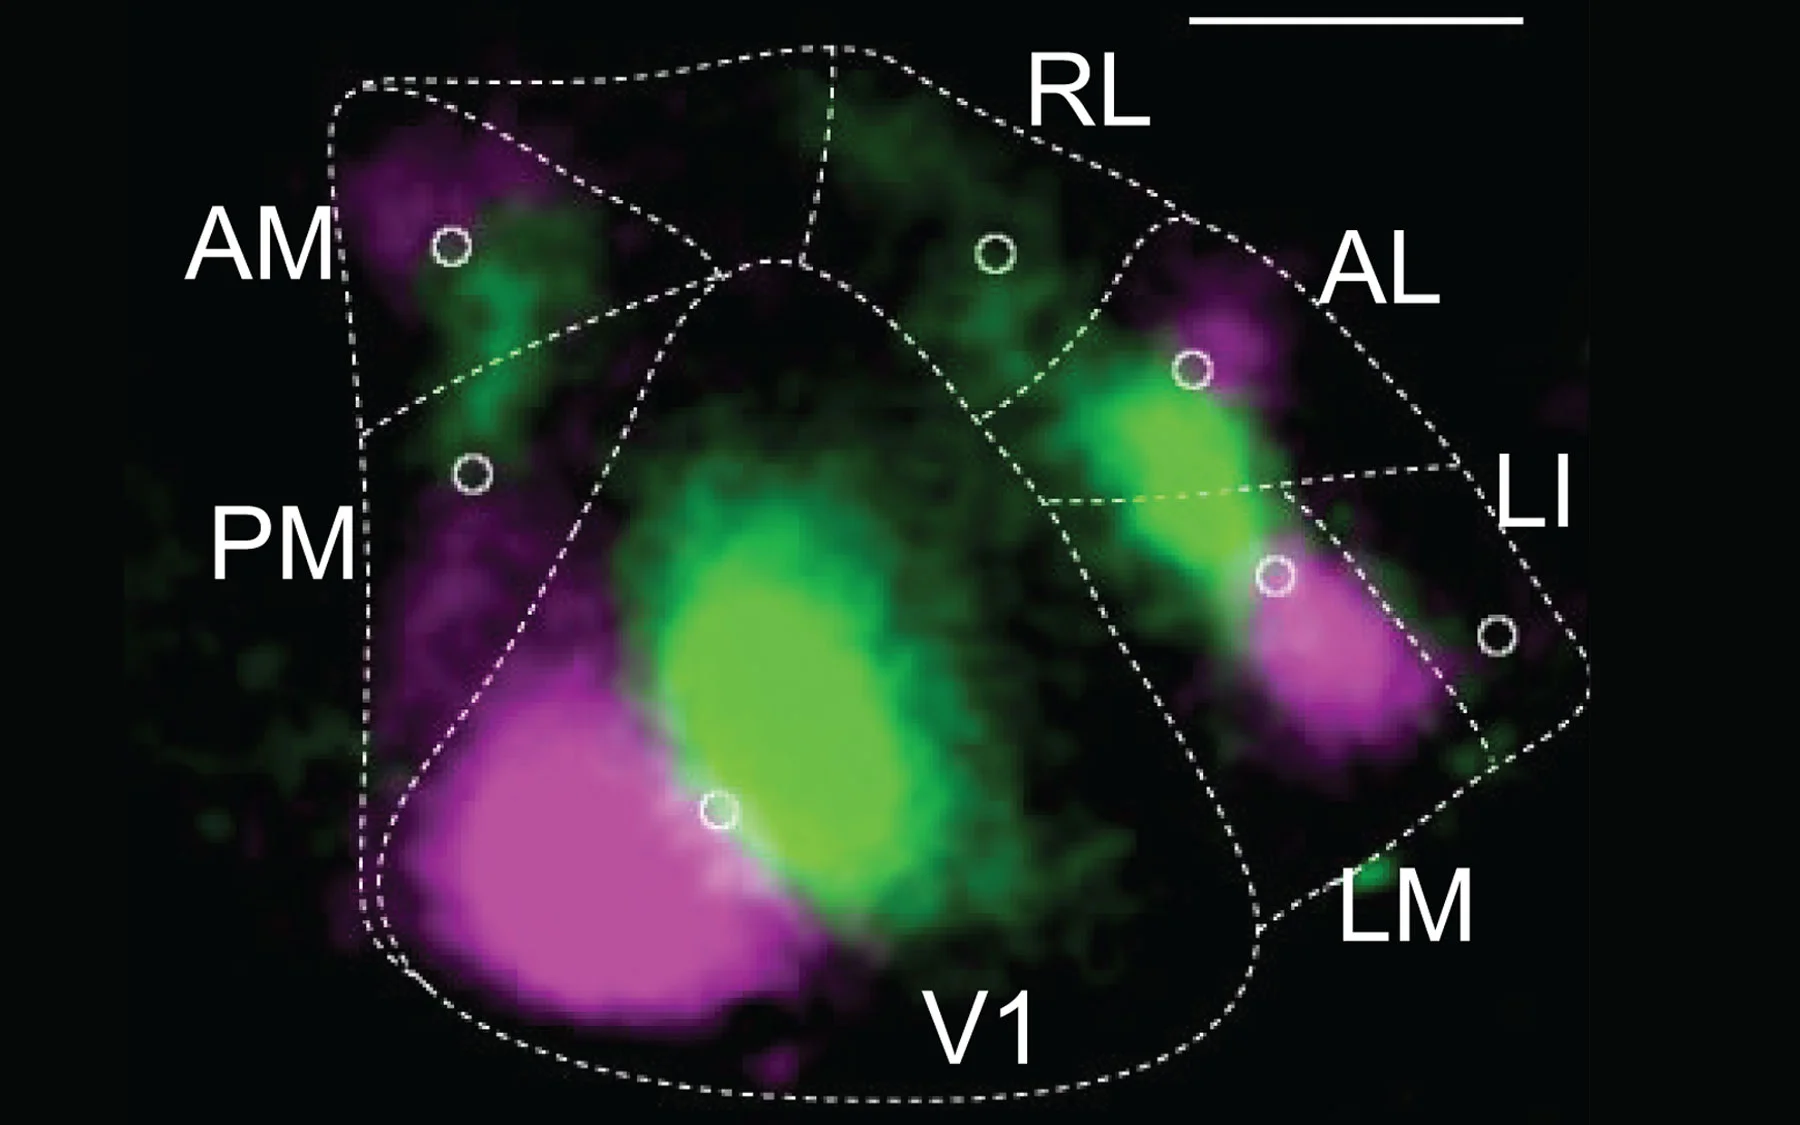<br>
[1] C. Department, “Revolutionary brain-mapping technique provides new blueprint for cortical connections,” Cold Spring Harbor Laboratory, https://www.cshl.edu/revolutionary-brain-mapping-technique-provides-new-blueprint-cortical-connections/ (accessed Dec. 1, 2023). 

    Notice below how the center area on x-y axis has much more sparse neuron samples than the other areas, this is comensurate with the "3Dpre_postNucleusDist" engineered feature plot in section 1.

    One hypothesis for this sparsity phenomenon could be that it is the transition barrier between V1 and Rl/AL as seen in the image above.

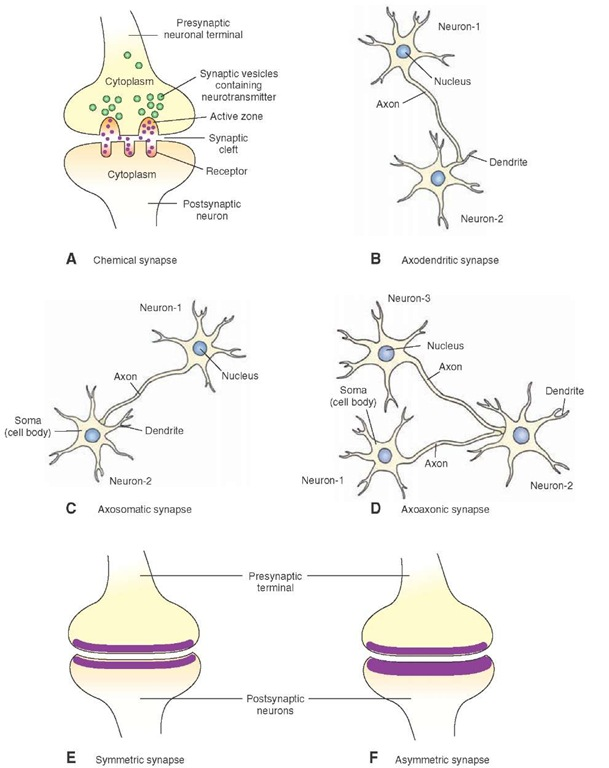<br>
    FIGURE 7-2 Morphology of a chemical synapse. (A) The presynaptic terminal and postsynaptic neuron are separated by a fluid-filled synaptic cleft. Note that the presynaptic terminal contains synaptic vesicles, which contain neurotransmitter and active zones. Receptors for the transmitter are located on the postsynaptic membrane. Different types of central nervous system synapses include (B) axodendritic synapse, (C) axosomatic synapse, and (D) axoaxonic synapse. (E) In a symmetrical synapse, the presynaptic and postsynaptic membranes are similar in thickness. (F) In an asymmetrical synapse, the postsynaptic membrane of a synapse is thicker than the presynaptic membrane.

[2]“Synaptic Transmission (The Neuron) Part 1,” what-when-how.com. http://what-when-how.com/neuroscience/synaptic-transmission-the-neuron-part-1/

## 2.1 Visual Interpretation

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Splitting features into numerical, categorical, and one to impute
numerical_features = ["fw_similarity", "coorX_difference", "coorY_difference", "coorZ_difference", "adp_dist", "pre_rf_y", "theta_btwn_2neurons",
                    "dendritic_coor_x", "dendritic_coor_y", "post_nucleus_id", "pre_nucleus_id", "ProdCoorDiff",
                    "dendritic_coor_z", "axonal_coor_x", "axonal_coor_y", "axonal_coor_z", "Combined_oracle",
                    "post_skeletal_distance_to_soma", "pre_skeletal_distance_to_soma", "pre_test_score", "pre_rf_x", 
                    "post_test_score", "post_rf_x", "post_rf_y", "Combined_testScore",
                    "pre_nucleus_x", "post_nucleus_x", 
                    "pre_nucleus_y", "post_nucleus_y", "pre_nucleus_z", "post_nucleus_z"
]
categorical_features = ["compartment", "pre_brain_area", "post_brain_area"]

predict_features = numerical_features + categorical_features

X_train, X_test, y_train, y_test = train_test_split(data[predict_features], data["connected"], test_size=0.1, random_state=5)

# Preprocessing: ColumnTransformer will handle encoding, scaling, and imputing for machine learning models
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop=None), categorical_features),
        #('impute', SimpleImputer(strategy='median'), ['morphEm_similarity'])
    ])

# Apply preprocessing to the data
X_processed = preprocessor.fit_transform(X_train)

# PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Target'] = y_train.reset_index(drop=True)

# Plot t-SNE
plt.figure(figsize=(10, 6))

# Plot non-connected samples first
sns.scatterplot(x='PC1', y='PC2', data=pca_df[pca_df['Target'] == 0], 
                color='lightblue', label='Non-Connected')

# Plot connected samples on top
sns.scatterplot(x='PC1', y='PC2', data=pca_df[pca_df['Target'] == 1], 
                color='darkblue', label='Connected')

plt.title('PCA Visualization')
plt.legend()
plt.show()

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=5)
X_tsne = tsne.fit_transform(X_processed)

# Creating a DataFrame for t-SNE results
tsne_df = pd.DataFrame(data=X_tsne, columns=['Component 1', 'Component 2'])
tsne_df['Target'] = y_train.reset_index(drop=True)

# Plot t-SNE
plt.figure(figsize=(10, 6))

# Ploting non-connected samples first
sns.scatterplot(x='Component 1', y='Component 2', data=tsne_df[tsne_df['Target'] == 0], 
                color='lightgreen', label='Non-Connected')

# Plot connected samples on top
sns.scatterplot(x='Component 1', y='Component 2', data=tsne_df[tsne_df['Target'] == 1], 
                color='darkgreen', label='Connected')

plt.title('t-SNE Visualization')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split

# Load the data
data = pd.read_csv("./train_data.csv")

_, data_sample = train_test_split(data, test_size=0.99, random_state=5, stratify=data['connected'])

# Filter only the connected neurons
connected_neurons = data_sample[data_sample['connected']]

# Create figure
fig = go.Figure()

# Add lines for each connected neuron pair
for index, neuron in connected_neurons.iterrows():
    # Extract axonal and dendritic coordinates
    axonal_coords = [neuron['axonal_coor_x'], neuron['axonal_coor_y'], neuron['axonal_coor_z']]
    dendritic_coords = [neuron['dendritic_coor_x'], neuron['dendritic_coor_y'], neuron['dendritic_coor_z']]

    # Plot line between axonal and dendritic coordinates
    fig.add_trace(go.Scatter3d(
        x=[axonal_coords[0], dendritic_coords[0]],
        y=[axonal_coords[1], dendritic_coords[1]],
        z=[axonal_coords[2], dendritic_coords[2]],
        mode='lines+markers+text',
        marker=dict(size=5, color='red'),
        line=dict(color='blue', width=2),
        text=[str(neuron['ID'])],
        textposition="bottom center"
    ))

# Update layout
fig.update_layout(
    title="3D Visualization of Connected Neurons",
    scene=dict(bgcolor='black', xaxis=dict(showgrid=False), yaxis=dict(showgrid=False), zaxis=dict(showgrid=False))
)

# Show plot
fig.show()


In [ ]:
import pandas as pd
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split

# Load the data
data = pd.read_csv("./train_data.csv")

# One-hot encode the categorical features
data_encoded = pd.get_dummies(data, columns=["pre_brain_area", "post_brain_area"])

# Sample 10% of the data, stratified by the 'connected' column
_, data_sample = train_test_split(data_encoded, test_size=0.99, random_state=5, stratify=data_encoded['connected'])

# Filter only the connected neurons
connected_neurons = data_sample[data_sample['connected']]

# Function to calculate line thickness
def calculate_line_thickness(oracle_value):
    return 1 + (abs(oracle_value - 0.70) / 0.10) * 0.5

# Create figure
fig = go.Figure()

# Function to calculate the centroid of a set of points
def calculate_centroid(points):
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    z_coords = [p[2] for p in points]
    return [np.mean(x_coords), np.mean(y_coords), np.mean(z_coords)]

# Function to generate a darker shade of a color
def darker_shade(color, factor=0.7):
    color = np.array(np.asarray(color) * factor, dtype=int)
    return f'rgb({color[0]}, {color[1]}, {color[2]})'

# Group neurons by brain area and plot
brain_area_groups = {
    'V1': [],
    'RL': [],
    'AL': [],
    # Add more groups if needed
}

# Define brain area colors in RGB format
brain_area_colors = {
    'V1': [0, 0, 255],      # Color for brain area V1 (Blue)
    'RL': [0, 255, 0],      # Color for brain area RL (Green)
    'AL': [255, 0, 0],      # Color for brain area AL (Red)
}

# Add traces for connected neurons
for i in connected_neurons.index:
    neuron = connected_neurons.loc[i]
    # Assign neuron to a group based on brain area
    if neuron['pre_brain_area_V1'] == 1:
        brain_area_groups['V1'].append((neuron['pre_nucleus_x'], neuron['pre_nucleus_y'], neuron['pre_nucleus_z']))
    elif neuron['pre_brain_area_RL'] == 1:
        brain_area_groups['RL'].append((neuron['pre_nucleus_x'], neuron['pre_nucleus_y'], neuron['pre_nucleus_z']))
    elif neuron['pre_brain_area_AL'] == 1:
        brain_area_groups['AL'].append((neuron['pre_nucleus_x'], neuron['pre_nucleus_y'], neuron['pre_nucleus_z']))
    
# Function to calculate the radius of the sphere
def calculate_radius(points, centroid):
    distances = [np.linalg.norm(np.array(point) - np.array(centroid)) for point in points]
    return max(distances)

# Plot each group with a centroid and a semi-transparent sphere
for area, points in brain_area_groups.items():
    if points:
        centroid = calculate_centroid(points)
        radius = calculate_radius(points, centroid)
        color_rgb = brain_area_colors.get(area, [128, 128, 128])  # Default to grey
        color_rgb_str = f'rgb({color_rgb[0]}, {color_rgb[1]}, {color_rgb[2]})'
        centroid_color = darker_shade(color_rgb, factor=0.7)

        # Add Sphere for group
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x_sphere = centroid[0] + radius * np.cos(u) * np.sin(v)
        y_sphere = centroid[1] + radius * np.sin(u) * np.sin(v)
        z_sphere = centroid[2] + radius * np.cos(v)

        fig.add_trace(go.Mesh3d(
            x=x_sphere.flatten(), y=y_sphere.flatten(), z=z_sphere.flatten(),
            alphahull=0,
            color=color_rgb_str,
            opacity=0.1
        ))

        # Add centroid
        fig.add_trace(go.Scatter3d(
            x=[centroid[0]],
            y=[centroid[1]],
            z=[centroid[2]],
            mode='markers',
            marker=dict(size=7, color=centroid_color),  # Centroid marked in gray
            name=f'Centroid - {area}, Radius: {radius}'
        ))

    # Calculate line thickness for axon and dendrite based on oracle values
    axon_line_thickness = calculate_line_thickness(neuron['pre_oracle'])
    dendrite_line_thickness = calculate_line_thickness(neuron['post_oracle'])

    # Determine the color based on one-hot encoded brain areas
    pre_brain_area_color = ('blue' if neuron['pre_brain_area_V1'] == 1 else 
                            'green' if neuron['pre_brain_area_RL'] == 1 else
                            'red' if neuron['pre_brain_area_AL'] == 1 else 
                            'grey')

    post_brain_area_color = ('lightblue' if neuron['post_brain_area_V1'] == 1 else
                            'lightgreen' if neuron['post_brain_area_RL'] == 1 else
                            'pink' if neuron['post_brain_area_AL'] == 1 else 
                            'grey')

    fig.add_trace(go.Scatter3d(
        x=[neuron['post_nucleus_x']],
        y=[neuron['post_nucleus_y']],
        z=[neuron['post_nucleus_z']],
        mode='markers',
        marker=dict(size=5, color=post_brain_area_color),
        #name=f'Post Nucleus (ID:{neuron["post_nucleus_id"]})'
    ))

# Set figure background color and title
fig.update_layout(
    scene=dict(
        bgcolor='rgba(0, 0, 0, 0)',  # Set the background color to transparent
        xaxis=dict(showbackground=False, gridcolor='rgba(255, 255, 255, 0)'),
        yaxis=dict(showbackground=False, gridcolor='rgba(255, 255, 255, 0)')
    )
)

# Update layout
fig.update_layout(
    title="Connected Neuron Brain Area group & centroid V1:Blue; RL:Green; AL:Red ",
    scene=dict(xaxis=dict(showgrid=False), yaxis=dict(showgrid=False), zaxis=dict(showgrid=False))
)

fig.show()

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split

# Load the data
data = pd.read_csv("./train_data.csv")

# One-hot encode the categorical features
data_encoded = pd.get_dummies(data, columns=["pre_brain_area", "post_brain_area"])

# Sample 10% of the data, stratified by the 'connected' column
_, data_sample = train_test_split(data_encoded, test_size=0.99, random_state=5, stratify=data_encoded['connected'])

# Filter only the connected neurons
connected_neurons = data_sample[data_sample['connected']]

# Function to calculate line thickness
def calculate_line_thickness(oracle_value):
    return 1 + (abs(oracle_value - 0.70) / 0.10) * 0.5

# Create figure
fig = go.Figure()

# Function to calculate the centroid of a set of points
def calculate_centroid(points):
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    z_coords = [p[2] for p in points]
    return [np.mean(x_coords), np.mean(y_coords), np.mean(z_coords)]

# Group neurons by brain area and plot
brain_area_groups = {
    'V1': [],
    'RL': [],
    'AL': [],
    # Add more groups if needed
}

# Add traces for connected neurons
for i in connected_neurons.index:
    neuron = connected_neurons.loc[i]
    # Assign neuron to a group based on brain area
    if neuron['pre_brain_area_V1'] == 1:
        brain_area_groups['V1'].append((neuron['pre_nucleus_x'], neuron['pre_nucleus_y'], neuron['pre_nucleus_z']))
    elif neuron['pre_brain_area_RL'] == 1:
        brain_area_groups['RL'].append((neuron['pre_nucleus_x'], neuron['pre_nucleus_y'], neuron['pre_nucleus_z']))
    elif neuron['pre_brain_area_AL'] == 1:
        brain_area_groups['AL'].append((neuron['pre_nucleus_x'], neuron['pre_nucleus_y'], neuron['pre_nucleus_z']))
    
    
    # Calculate line thickness for axon and dendrite based on oracle values
    axon_line_thickness = calculate_line_thickness(neuron['pre_oracle'])
    dendrite_line_thickness = calculate_line_thickness(neuron['post_oracle'])

    # Determine the color based on one-hot encoded brain areas
    pre_brain_area_color = ('blue' if neuron['pre_brain_area_V1'] == 1 else 
                            'green' if neuron['pre_brain_area_RL'] == 1 else
                            'red' if neuron['pre_brain_area_AL'] == 1 else 
                            'grey')

    post_brain_area_color = ('lightblue' if neuron['post_brain_area_V1'] == 1 else
                            'lightgreen' if neuron['post_brain_area_RL'] == 1 else
                            'pink' if neuron['post_brain_area_AL'] == 1 else 
                            'grey')

    # Nucleus points
    fig.add_trace(go.Scatter3d(
        x=[neuron['pre_nucleus_x']],
        y=[neuron['pre_nucleus_y']],
        z=[neuron['pre_nucleus_z']],
        mode='markers',
        marker=dict(size=5, color=pre_brain_area_color),
        name=f'Pre Nucleus (ID:{neuron["pre_nucleus_id"]})'
    ))

    fig.add_trace(go.Scatter3d(
        x=[neuron['post_nucleus_x']],
        y=[neuron['post_nucleus_y']],
        z=[neuron['post_nucleus_z']],
        mode='markers',
        marker=dict(size=5, color=post_brain_area_color),
        name=f'Post Nucleus (ID:{neuron["post_nucleus_id"]})'
    ))

# Set figure background color and title
fig.update_layout(
    scene=dict(
        bgcolor='rgba(0, 0, 0, 0)',  # Set the background color to transparent
        xaxis=dict(showbackground=False, gridcolor='rgba(255, 255, 255, 0)'),
        yaxis=dict(showbackground=False, gridcolor='rgba(255, 255, 255, 0)')
    )
)

# Update layout
fig.update_layout(
    title="Connected neuron members in respective Brain Area V1:Blue; RL:Green; AL:Red ",
    scene=dict(xaxis=dict(showgrid=False), yaxis=dict(showgrid=False), zaxis=dict(showgrid=False))
)

# Show plot
fig.show()
# Save the figure USER-->->-> Enter your own path below!!!
plot_file = "/Users/DomDuliepre/Desktop/3d_connected_neurons0.html"
fig.write_html(plot_file)

plot_file

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split

# Load the data
data = pd.read_csv("./train_data.csv")  # Ensure this path is correct

# One-hot encode the categorical features
data_encoded = pd.get_dummies(data, columns=["pre_brain_area", "post_brain_area"])

# Assuming 'data' is your DataFrame after loading 'train_data.csv'
_, data_sample = train_test_split(data, test_size=0.99, random_state=5, stratify=data['connected'])

# Filter only the connected neurons
connected_neurons = data_sample[data_sample['connected']]

# Create figure
fig = go.Figure()

# Add traces for connected neurons
for i in connected_neurons.index:
    neuron = connected_neurons.loc[i]
    
    # Nucleus point
    fig.add_trace(go.Scatter3d(
        x=[neuron['pre_nucleus_x'], neuron['post_nucleus_x']],
        y=[neuron['pre_nucleus_y'], neuron['post_nucleus_y']],
        z=[neuron['pre_nucleus_z'], neuron['post_nucleus_x']],
        mode='markers',
        marker=dict(size=5, color='black'),  # Larger and yellow nucleus
        name=f'Nucleus {i}'
    ))
    """
    # Connection from dendritic to axonal
    fig.add_trace(go.Scatter3d(
        x=[neuron['dendritic_coor_x'], neuron['axonal_coor_x']],
        y=[neuron['dendritic_coor_y'], neuron['axonal_coor_y']],
        z=[neuron['dendritic_coor_z'], neuron['axonal_coor_z']],
        mode='lines+markers',
        marker=dict(size=2, color='red'),  # Smaller and red for synapse
        line=dict(color='green', width=2),  # Connection line in white
        name=f'Synapse: Pre-Post Nucleus ID:{neuron["pre_nucleus_id"]}->{neuron["post_nucleus_id"]}'
    ))
"""
# Set figure background color
fig.update_layout(scene=dict(bgcolor='black'),
                  title_text='3D Scatter Plot of Connected Neurons')

# Show plot
fig.show()
# Save the figure USER-->->-> Enter your own path below!!!
plot_file = "/Users/DomDuliepre/Desktop/3d_connected_neurons1.html"
fig.write_html(plot_file)

plot_file


    "The neuron that formed the synapse with its axon is called the pre-synaptic neuron, and the neuron that formed the synapse with its dendrite is called the post-synaptic neuron. Synapses vary in size, and large synapses indicate a stronger connection between neurons"
    -- MICrONS Function - Connectivity Data Documentation

Below is a 3D intereactive plot depicting the connected neurons in the "./train_data.csv" data in light blue connected via line (red/green representing their axons/dendrites) to their respective synapse locations in dark blue.

The synapse locations are computed vis-à-vis the 3D axon-dendrite coordinates of the neurons from which is half way between the 3D coordinates of the pre-synaptic axons and post-synaptic dendrites.


In [ ]:
import pandas as pd
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split

# Load the data
data = pd.read_csv("./train_data.csv")  # Ensure this path is correct

# One-hot encode the categorical features
data_encoded = pd.get_dummies(data, columns=["pre_brain_area", "post_brain_area"])

# Sample 1% of the data, stratified by the 'connected' column
_, data_sample = train_test_split(data, test_size=0.99, random_state=5, stratify=data['connected'])

# Filter only the connected neurons
connected_neurons = data_sample[data_sample['connected']]
connected_neurons = connected_neurons[['ID', 
                                       'axonal_coor_x', 'axonal_coor_y', 'axonal_coor_z', 
                                       'dendritic_coor_x', 'dendritic_coor_y', 'dendritic_coor_z',
                                       'pre_nucleus_x', 'pre_nucleus_y', 'pre_nucleus_z',
                                       'post_nucleus_x', 'post_nucleus_y', 'post_nucleus_z',
                                       'pre_nucleus_id', 'post_nucleus_id']]

# Create figure
fig = go.Figure()
# Define colors for the bubbles
bubble_colors = {
    'V1': 'blue',
    'RL': 'green',
    'AL': 'red',
    # Add more colors if needed
}
# Add traces for connected neurons
for i in connected_neurons.index:
    neuron = connected_neurons.loc[i]
    
    # Nucleus points
    fig.add_trace(go.Scatter3d(
        x=[neuron['pre_nucleus_x'], neuron['post_nucleus_x']],
        y=[neuron['pre_nucleus_y'], neuron['post_nucleus_y']],
        z=[neuron['pre_nucleus_z'], neuron['post_nucleus_z']],
        mode='markers',
        marker=dict(size=5, color='rgb(166,206,227)'),  # Larger and yellow for nucleus
        name=f'Neuron {neuron["ID"]}'
    ))
    
    # Synapse point (small ball at the midpoint of the connection)
    midpoint_x = (neuron['dendritic_coor_x'] + neuron['axonal_coor_x']) / 2
    midpoint_y = (neuron['dendritic_coor_y'] + neuron['axonal_coor_y']) / 2
    midpoint_z = (neuron['dendritic_coor_z'] + neuron['axonal_coor_z']) / 2
    fig.add_trace(go.Scatter3d(
        x=[midpoint_x],
        y=[midpoint_y],
        z=[midpoint_z],
        mode='markers',
        marker=dict(size=2, color='blue'),  # Small and blue for synapse
        name='Synapse'
    ))

    # Draw lines representing axon and dendrite connections to their respective nuclei
    # Axon to post-nucleus
    fig.add_trace(go.Scatter3d(
        x=[neuron['post_nucleus_x'], neuron['axonal_coor_x']],
        y=[neuron['post_nucleus_y'], neuron['axonal_coor_y']],
        z=[neuron['post_nucleus_z'], neuron['axonal_coor_z']],
        mode='lines',
        line=dict(color='red', width=1),
        name=f'Axon (Pre Nucleus: ID:{neuron["pre_nucleus_id"]})'
    ))

    # Dendrite to pre-nucleus
    fig.add_trace(go.Scatter3d(
        x=[neuron['pre_nucleus_x'], neuron['dendritic_coor_x']],
        y=[neuron['pre_nucleus_y'], neuron['dendritic_coor_y']],
        z=[neuron['pre_nucleus_z'], neuron['dendritic_coor_z']],
        mode='lines',
        line=dict(color='green', width=1),
        name=f'Dendrite (Post Nucleus: ID:{neuron["post_nucleus_id"]})'
    ))

# Set figure background color and title
fig.update_layout(
    scene=dict(
        bgcolor='rgba(0, 0, 0, 0)',  # Set the background color to transparent
        xaxis=dict(showbackground=False, gridcolor='rgba(255, 255, 255, 0)'),
        yaxis=dict(showbackground=False, gridcolor='rgba(255, 255, 255, 0)'),
        zaxis=dict(showbackground=False, gridcolor='rgba(255, 255, 255, 0)')
    ))

fig.show()
# Save the figure USER-->->-> Enter your own path below!!!
plot_file = "/Users/DomDuliepre/Desktop/3d_connected_neurons2.html"
fig.write_html(plot_file)

plot_file

    "Metric of neuronal response reliability to repeated visual stimulus pre- sentation"
    -- MICrONS Function - Connectivity Data Documentation

    The "pre-oracle" and "post-oracle": 
    Building from the above representation: Bellow are variable axon/dendrite line thickness to represent the pre- and post-oracle reliability of the neuronal responses. The line thickness initiated at 0.5 for 0.70 oracle score and increases accordingly.

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split

# Load the data
data = pd.read_csv("./train_data.csv")  # Ensure this path is correct

# One-hot encode the categorical features
data_encoded = pd.get_dummies(data, columns=["pre_brain_area", "post_brain_area"])

# Sample 1% of the data, stratified by the 'connected' column
_, data_sample = train_test_split(data, test_size=0.9, random_state=5, stratify=data['connected'])

# Filter only the connected neurons
connected_neurons = data_sample[data_sample['connected']]
connected_neurons = connected_neurons[['ID', 
                                       'axonal_coor_x', 'axonal_coor_y', 'axonal_coor_z', 
                                       'dendritic_coor_x', 'dendritic_coor_y', 'dendritic_coor_z',
                                       'pre_nucleus_x', 'pre_nucleus_y', 'pre_nucleus_z',
                                       'post_nucleus_x', 'post_nucleus_y', 'post_nucleus_z',
                                       'pre_nucleus_id', 'post_nucleus_id']]

# Filter only the connected neurons
connected_neurons = data_sample[data_sample['connected']]

# Create figure
fig = go.Figure()

# Function to calculate line thickness
def calculate_line_thickness(oracle_value):
    return 0.5 + (abs(oracle_value - 0.70) / 0.10) * 0.5

# Add traces for connected neurons
for i in connected_neurons.index:
    neuron = connected_neurons.loc[i]
    
    # Calculate line thickness for axon and dendrite based on oracle values
    axon_line_thickness = calculate_line_thickness(neuron['pre_oracle'])
    dendrite_line_thickness = calculate_line_thickness(neuron['post_oracle'])

    # Nucleus points
    fig.add_trace(go.Scatter3d(
        x=[neuron['pre_nucleus_x'], neuron['post_nucleus_x']],
        y=[neuron['pre_nucleus_y'], neuron['post_nucleus_y']],
        z=[neuron['pre_nucleus_z'], neuron['post_nucleus_z']],
        mode='markers',
        marker=dict(size=5, color='rgb(166,206,227)'),  # Larger and yellow for nucleus
        name=f'Neuron {neuron["ID"]}'
    ))
    
    # Synapse point (small ball at the midpoint of the connection)
    midpoint_x = (neuron['dendritic_coor_x'] + neuron['axonal_coor_x']) / 2
    midpoint_y = (neuron['dendritic_coor_y'] + neuron['axonal_coor_y']) / 2
    midpoint_z = (neuron['dendritic_coor_z'] + neuron['axonal_coor_z']) / 2
    fig.add_trace(go.Scatter3d(
        x=[midpoint_x],
        y=[midpoint_y],
        z=[midpoint_z],
        mode='markers',
        marker=dict(size=2, color='blue'),  # Small and blue for synapse
        name='Synapse'
    ))

    # Draw lines representing axon and dendrite connections to their respective nuclei
    # Axon to post-nucleus
    fig.add_trace(go.Scatter3d(
        x=[neuron['post_nucleus_x'], neuron['axonal_coor_x']],
        y=[neuron['post_nucleus_y'], neuron['axonal_coor_y']],
        z=[neuron['post_nucleus_z'], neuron['axonal_coor_z']],
        mode='lines',
        line=dict(color='red', width=dendrite_line_thickness),
        name=f'Axon (Pre Nucleus: ID:{neuron["pre_nucleus_id"]}, Thickness: {axon_line_thickness: .2f})'
    ))

    # Dendrite to pre-nucleus
    fig.add_trace(go.Scatter3d(
        x=[neuron['pre_nucleus_x'], neuron['dendritic_coor_x']],
        y=[neuron['pre_nucleus_y'], neuron['dendritic_coor_y']],
        z=[neuron['pre_nucleus_z'], neuron['dendritic_coor_z']],
        mode='lines',
        line=dict(color='green', width=axon_line_thickness),
        name=f'Dendrite (Post Nucleus: ID:{neuron["post_nucleus_id"]}, Thickness: {dendrite_line_thickness: .2f})'
    ))

# Set figure background color and title
fig.update_layout(
    scene=dict(
        bgcolor='rgba(0, 0, 0, 0)',  # Set the background color to transparent
        xaxis=dict(showbackground=False, gridcolor='rgba(255, 255, 255, 0)'),
        yaxis=dict(showbackground=False, gridcolor='rgba(255, 255, 255, 0)')
    )
)

fig.show()
# Save the figure USER-->->-> Enter your own path below!!!
plot_file = "/Users/DomDuliepre/Desktop/3d_connected_neurons3.html"
fig.write_html(plot_file)

plot_file

## 2.2 Analytical Interpretation: Feature Importance plot of Logistic Regression V.S. AdaBoost V.S. Perceptron, V.S. Bernoulli Naive Bayes V.S. QDA

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE, SVMSMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn_crfsuite import CRF
from xgboost import XGBClassifier
from minisom import MiniSom
import matplotlib.pyplot as plt
from hmmlearn import hmm
import numpy as np

# Feature list
predict_features = ["fw_similarity", "adp_dist", "dendritic_coor_x", "dendritic_coor_y",
                   "post_nucleus_id", "pre_nucleus_id", "dendritic_coor_z", "axonal_coor_x",
                   "axonal_coor_y", "post_skeletal_distance_to_soma",
                   "pre_skeletal_distance_to_soma", "pre_oracle", "pre_test_score",
                   "pre_rf_y", "post_oracle", "post_test_score",
                   "compartment", "pre_brain_area", "post_brain_area"]

X_train, X_test, y_train, y_test = train_test_split(data[predict_features], data["connected"], test_size=0.399, random_state=5)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), slice(0, -3)),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), slice(-3, None))
    ])
resampler =RandomOverSampler(random_state=5)
X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)

models_and_parameters = {
    'LogisticRegression': {
        'model': LogisticRegression(random_state=5, max_iter=5000),
        'params': {'model__C': np.logspace(-2, 2, 10), 'model__class_weight': [None, 'balanced']}
    },
    'Perceptron': {
        'model': Perceptron(),
        'params': {'model__max_iter': [1000, 5000], 'model__tol': [1e-3, 1e-4]}
    },
    'AdaBoostClassifier': {
        'model': AdaBoostClassifier(),
        'params': {'model__n_estimators': [50, 100], 'model__learning_rate': [0.05, 0.1, 0.5]}
    },
    'MultinomialNB': {
        'model': MultinomialNB(),
        'params': {'model__alpha': [0.1, 1.0, 10.0]}
    },
    'BernoulliNB': {
        'model': BernoulliNB(),
        'params': {'model__alpha': [0.1, 1.0, 10.0]}
    },
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {'model__n_neighbors': [3, 5, 7], 'model__weights': ['uniform', 'distance']}
    },
    'QuadraticDiscriminantAnalysis': {
        'model': QuadraticDiscriminantAnalysis(),
        'params': {}
    },
    'LinearDiscriminantAnalysis': {
        'model': LinearDiscriminantAnalysis(),
        'params': {'model__solver': ['svd', 'lsqr']}
    },
}

X_temp = preprocessor.fit_transform(X_resampled)

if (X_temp < 0).any():
    del models_and_parameters['MultinomialNB']

for model_name, mp in models_and_parameters.items():
    # Construct pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', mp['model'])
    ])

    # Grid search
    clf = GridSearchCV(pipeline, mp['params'], cv=5, scoring='balanced_accuracy', n_jobs=-1)
    clf.fit(X_resampled, y_resampled)

    # Predict and evaluate
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

    # Output results
    print(f"{model_name}:")
    print(f"Best hyperparameters: {clf.best_params_}")
    print(f"Accuracy: {accuracy:}")
    print(f"Balanced Accuracy: {balanced_accuracy:}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")

    # Handling feature names after one-hot encoding for plotting
    feature_names_after_encoding = (clf.best_estimator_.named_steps['preprocessor']
                                    .named_transformers_['cat']
                                    .get_feature_names_out(predict_features[-3:]))
    all_feature_names = np.concatenate([predict_features[:-3], feature_names_after_encoding])

    best_model = clf.best_estimator_.named_steps['model']

    # Feature Importance / Coefficients
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        sorted_idx = np.argsort(importances)[::-1]
        plt.figure(figsize=(10, 5))
        plt.barh(all_feature_names[sorted_idx], importances[sorted_idx])
        plt.xlabel("Feature Importance")
        plt.ylabel("Feature")
        plt.title(f"Feature Importance for {model_name}")
        plt.show()

    elif hasattr(best_model, 'coef_'):
        coefficients = best_model.coef_[0]
        sorted_idx = np.argsort(np.abs(coefficients))[::-1]
        plt.figure(figsize=(10, 5))
        plt.barh(all_feature_names[sorted_idx], coefficients[sorted_idx])
        plt.xlabel("Coefficient Magnitude")
        plt.ylabel("Feature")
        plt.title(f"Coefficients for {model_name}")
        plt.show()

# Predict directly using the pipeline (which includes the preprocessor)
lb_data["pred"] = clf.predict(lb_data[predict_features])
lb_data["connected"] = lb_data["pred"] > .5

The performance of the different machine learning models vary significantly based on the characteristics of the data. In this case, several factors explain why models like logistic regression, perceptron, naive Bayes, K-neighbors, and discriminant analysis performed poorly compared to boosting models like ADABoost and later XGBoost. 

Considerations:

1. **Complexity of the Data:** 
   - The dataset seems to involve complex relationships and interactions among features. Boosting models, are known for handling complex data well because they iteratively correct the mistakes (residuals) of prior models and can capture complex patterns in the data.
   - On the other hand, models like logistic regression or naive Bayes might have been too simple to capture these complexities. Logistic regression, for instance, assumes a linear relationship between features and the target variable.

2. **Non-Linearity:** 
   - The data contains non-linear relationships as seen in the cluster Heat Map below, models that inherently assume linearity (like logistic regression and linear discriminant analysis) were suspected to not perform as well. 
   - Boosting models do not assume any specific linearity and are capable of modeling more complex, non-linear relationships.

3. **High-Dimensional Space:**
   - The dataset has a relatively high number of features, especially after one-hot encoding categorical variables. Some models like K-neighbors classifier were also suspected to not perform as well in high-dimensional spaces due to the curse of dimensionality.
   - Boosting models, however, can handle high-dimensional data more effectively.

4. **Class Imbalance:**
   - The dataset also suffers from class imbalance, techniques like boosting can handle imbalanced data better, especially when combined with oversampling techniques.

5. **Feature Interactions:**
   - Boosting models, especially tree-based ones like XGBoost, are excellent at capturing interactions between features prior to explicit feature engineering.
   - Models like naive Bayes or perceptron might not capture these interactions effectively, leading to poorer performance.

6. **Hyperparameter Tuning:**
   - After ruling out the models which performed the poorest(ADABoost among the best), a consensus was made to use trees and boosting trees. It's evident that the boosting models performed better specially when tuned for the specific dataset than the other models.

7. **Model Assumptions:**
   - Each model comes with its own set of assumptions. For example, naive Bayes assumes feature independence, and if this assumption is violated (which is common here), it can lead to poor performance.
   - Boosting models are less rigid in their assumptions about data, making them more flexible and adaptable to various datasets.

In summary, the superiority of boosting models in such case could be attributed to their ability to handle complex, high-dimensional, and non-linear data, along with their flexibility in their robustness to the curse of dimensionality and class imbalance. These were our justifications for the transition to Phase 2 as such.

## 3.0. Heatmap; Cluster Map via Logistic Regression; and Pair Plot of fitted degree-2 polynomial vis-à-vis Polynomial Regresssion

### The interpretation techniques just below confirms our initial understanding of the data and why each of the models applied performed the way they did.

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE, SVMSMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn_crfsuite import CRF
from xgboost import XGBClassifier
from minisom import MiniSom
import matplotlib.pyplot as plt
from hmmlearn import hmm
import seaborn as sns
import numpy as np

# Feature list
predict_features = ["fw_similarity", "adp_dist", "dendritic_coor_x", "dendritic_coor_y",
            "post_nucleus_id", "pre_nucleus_id", "dendritic_coor_z", "axonal_coor_x",
            "axonal_coor_y", "axonal_coor_z", "post_skeletal_distance_to_soma",
            "pre_skeletal_distance_to_soma", "pre_oracle", "pre_test_score",
            "pre_rf_x", "pre_rf_y", "post_oracle", "post_test_score",
            "post_rf_x", "compartment", "pre_brain_area", "post_brain_area"]

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(data[predict_features], data["connected"])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), slice(0, -3)),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), slice(-3, None))
    ])
preprocessed_data = preprocessor.fit_transform(data[predict_features])

models_and_parameters = {
    'LogisticRegression': {
        'model': LogisticRegression(random_state=5, max_iter=5000),
        'params': {'model__C': np.logspace(-2, 2, 10), 'model__class_weight': [None, 'balanced']}
    },
}

for model_name, mp in models_and_parameters.items():
    # Construct pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', mp['model'])
    ])

    # Grid search
    clf = GridSearchCV(pipeline, mp['params'], cv=5, scoring='balanced_accuracy', n_jobs=-1)
    clf.fit(X_resampled, y_resampled)

preprocessed_data = preprocessor.transform(data[predict_features])
columns_after_preprocessing = (predict_features[:-3] +
                              list(clf.best_estimator_.named_steps['preprocessor']
                                .named_transformers_['cat']
                                .get_feature_names_out(predict_features[-3:])))

preprocessed_df = pd.DataFrame(preprocessed_data, columns=columns_after_preprocessing)

corr_matrix_all = preprocessed_df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))

if "connected" in data.columns:
    # Adding the 'connected' column to our preprocessed DataFrame for visualization
    preprocessed_df['connected'] = data["connected"]

sns.clustermap(preprocessed_df.drop('connected', axis=1),
               method='ward',
               cmap='coolwarm',
               standard_scale=1,
               figsize=(15, 15))
plt.show()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Draw the heatmap
sns.heatmap(corr_matrix_all, cmap='coolwarm',
                            vmax=1, vmin=-1, center=0,
                            square=True, linewidths=.5,
                            cbar_kws={"shrink": 0.75},
                            annot=True, fmt='.2f')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Correlation Matrix for all Features", fontsize=32)
plt.show()

if "connected" in data.columns:
    # Adding the 'connected' column to our preprocessed DataFrame for visualization
    preprocessed_df['connected'] = data["connected"]

    # Pair plot using the 'connected' column as hue
    sns.pairplot(preprocessed_df, hue="connected", kind='reg', plot_kws={'order': 2})
    plt.xticks(fontsize=12, rotation=90)
    plt.yticks(fontsize=12, rotation=90)
    plt.title("Pair plot with deg-2 polynomial fitted in each cell Connected:Orange; else:Blue")
    plt.show()
else:
    print("The 'connected' column DNE in the data!")

## 4.0. XGBoost Feature Importance Plot

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold, StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import numpy as np

# Splitting features into numerical, categorical, and one to impute
numerical_features = ["coorZ_difference", "coorY_difference", "coorX_difference",
                    "adp_dist", "post_skeletal_distance_to_soma", "pre_rf_y", "pre_skeletal_distance_to_soma",
                    "dendritic_coor_x", "dendritic_coor_y", "fw_similarity", "post_nucleus_id",
                    "pre_nucleus_id", "dendritic_coor_z", "axonal_coor_x", "postRadialLocation",
                    "axonal_coor_y", "axonal_coor_z", "3Dax_denDist", "preRadialLocation", 
                    "pre_test_score", "pre_rf_x", "post_test_score", "3Dpre_postNucleusDist",
                    "post_rf_x", "theta_btwn_2neurons", "Combined_oracle", "Combined_testScore",
                    "CumCoorDiff", "EDax_denDistSquared", "ProdCoorDiff", "morphEm_similarity"
]
categorical_features = ["compartment", "pre_brain_area", "post_brain_area"]
predict_features = numerical_features + categorical_features

# Split the data
X = data[predict_features]
y = data["connected"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

# Preprocessing: ColumnTransformer will handle encoding, scaling, and imputing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop=None), categorical_features),
        ('impute', SimpleImputer(strategy='median'), ['morphEm_similarity'])
    ])

# Define resampling and model parameters
resampler = RandomOverSampler(random_state=5)
model = xgb.XGBClassifier()
params = {
    'model__n_estimators': [135],
    'model__learning_rate': [0.0001],
    'model__max_depth': [6],
    'model__subsample': [1.0],
    'model__colsample_bytree': [0.2],
    'model__gamma': [0.001]
}

# Create a pipeline that first applies the preprocessor, then resamples, and then runs the classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('resampler', resampler),
    ('model', model)
])

# Use StratifiedShuffleSplit for cross-validation
stratified_split = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=5)

# Perform grid search
clf = GridSearchCV(pipeline, params, cv=stratified_split, scoring='balanced_accuracy')
clf.fit(X_train, y_train)

# Get predictions and evaluate the model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# Output results
print("Best hyperparameters:", clf.best_params_)
print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)

# Get feature names after preprocessing (numerical + one-hot encoded categorical features)
feature_names_transformed = list(clf.best_estimator_.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()) + \
                            list(clf.best_estimator_.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out()) + \
                            numerical_features[-1:]  # Assuming 'morphEm_similarity' is the last numerical feature to be imputed

# Create the preprocessed DataFrame
X_train_preprocessed = clf.best_estimator_.named_steps['preprocessor'].transform(X_train)
preprocessed_df_train = pd.DataFrame(X_train_preprocessed, columns=feature_names_transformed)
preprocessed_df_train['connected'] = y_train.reset_index(drop=True)  # Reset index to avoid index misalignment

# 6. Cluster Map: Average linkage 
#plt.figure(figsize=(30, 20))  # Adjust the figure size as needed
sns.clustermap(preprocessed_df_train.corr(), method='average', cmap='coolwarm', center=0,
               linewidths=.75, annot=False, fmt='.2f')
plt.title(f"Cluster Map of Feature Correlation Linkage: Average", fontsize=32)
#plt.xticks(fontsize=9)  
#plt.yticks(fontsize=9)  
plt.show()

In [ ]:
# 1. Plotting the top 10 features with distinct colors for each bar

# 4. Feature Importance Plot
best_model = clf.best_estimator_.named_steps['model']
feature_importances = best_model.feature_importances_

# Sorting and selecting top 10 features in descending order
sorted_indices = np.argsort(feature_importances)[-10:][::-1]
top_feature_names = np.array(feature_names_transformed)[sorted_indices]
top_feature_importances = feature_importances[sorted_indices]

# Generate a color palette with one color for each bar
palette = sns.color_palette('colorblind', 10)  # 'hsv' is just one of the many available palettes

plt.figure(figsize=(6, 5))
sns.barplot(x=top_feature_importances, y=top_feature_names, palette=palette)
plt.title('Top 10 Feature Importance Plot for XGBoost', fontsize=32)
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12) 
plt.show()

In [ ]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

"""
# 2. Pair Plot
pair_plot_features = numerical_features[:19]  # Select a subset of features for the pair plot
sns.pairplot(preprocessed_df_train[pair_plot_features + ['connected']], hue="connected")
plt.title("Pair Plot for Preprocessed Features", fontsize=32)
plt.show()
"""

# 3. Corr. Matrix with Annotations
corr_matrix = preprocessed_df_train.corr()
plt.figure(figsize=(30, 20))  # Adjust the figure size as needed
sns.heatmap(corr_matrix, linewidths=.75, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix for all Features", fontsize=32)
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12) 
plt.show()

In [ ]:
# 5. Cluster Map: Ward Linkage
plt.figure(figsize=(30, 30))  # Increase the figure size
sns.clustermap(preprocessed_df_train.corr(), method='ward', cmap='coolwarm', center=0,
               linewidths=.75, annot=False)
plt.title("Cluster Map of Feature Correlation (Ward Linkage)", fontsize=20)
plt.xticks(rotation=0, fontsize=10)  # Rotate and adjust font size for better readability
plt.yticks(rotation=0, fontsize=10)
plt.show()

# 6. Cluster Map: Average Linkage 
plt.figure(figsize=(20, 20))  # Increase the figure size
sns.clustermap(preprocessed_df_train.corr(), method='average', cmap='coolwarm', center=0,
               linewidths=.75, annot=False)
plt.title("Cluster Map of Feature Correlation (Average Linkage)", fontsize=20)
plt.xticks(rotation=0, fontsize=1)  # Rotate and adjust font size for better readability
plt.yticks(rotation=0, fontsize=1)
plt.show()

In [ ]:
# Spliting the correlation matrix into smaller sections since previous single plot is skipping features (possibly due to space/dimension limitations)
def split_corr_matrix(corr_matrix, n_splits):
    split_size = corr_matrix.shape[0] // n_splits
    for i in range(n_splits):
        yield corr_matrix.iloc[i*split_size:(i+1)*split_size, i*split_size:(i+1)*split_size]

# Plot each split correlation matrix
n_splits = 4  # Number of splits
for i, small_corr_matrix in enumerate(split_corr_matrix(preprocessed_df_train.corr(), n_splits)):
    plt.figure(figsize=(5, 5))
    sns.clustermap(small_corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', method='ward', center=0, linewidths=.5)
    plt.title(f"Cluster Map of Feature Correlation - Section {i+1} (Ward Linkage)", fontsize=20)
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.show()


In [ ]:
# Spliting the correlation matrix into smaller sections since previous single plot is skipping features (possibly due to space/dimension limitations)
def split_corr_matrix(corr_matrix, n_splits):
    split_size = corr_matrix.shape[0] // n_splits
    for i in range(n_splits):
        yield corr_matrix.iloc[i*split_size:(i+1)*split_size, i*split_size:(i+1)*split_size]

# Ploting each split correlation matrix
n_splits = 2  # Number of splits
for i, small_corr_matrix in enumerate(split_corr_matrix(preprocessed_df_train.corr(), n_splits)):
    plt.figure(figsize=(5, 5))
    sns.clustermap(small_corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', method='average', center=0, linewidths=.5)
    plt.title(f"Cluster Map of Feature Correlation - Section {i+1} (Average Linkage)", fontsize=20)
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.show()


In [ ]:
# Spliting the correlation matrix into smaller sections
def split_corr_matrix(corr_matrix, n_splits):
    split_size = corr_matrix.shape[0] // n_splits
    for i in range(n_splits):
        yield corr_matrix.iloc[i*split_size:(i+1)*split_size, i*split_size:(i+1)*split_size]

# Ploting each split correlation matrix
n_splits = 2  # Number of splits
for i, small_corr_matrix in enumerate(split_corr_matrix(preprocessed_df_train.corr(), n_splits)):
    plt.figure(figsize=(5, 5))
    sns.clustermap(small_corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', method='ward', center=0, linewidths=.5)
    plt.title(f"Cluster Map of Feature Correlation - Section {i+1} (Ward Linkage)", fontsize=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()